In [ ]:
#| default_exp examples.mcp_agent

## MCP Agent

This example demonstrates how to create a stringdale diagram that implements a complete MCP tool selection cycle:
1. User query input
2. LLM selects tool from available MCP tools
3. Execute selected tool via MCP client
4. Analyze tool output
5. Loop back or return final answer


In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| hide
from stringdale.core import get_git_root, load_env, checkLogs
load_env()


True

In [ ]:

from typing import Optional, List, Dict, Any
from pydantic import BaseModel, Field
from stringdale import Define, V, E, Condition, Scope
from stringdale.chat import Chat
import os

from fastmcp import Client
import asyncio


We are using the weather tool from the weather_server.py file.

In [ ]:
weather_path = str(get_git_root()/"stringdale/mcp_weather_server.py")
config = {
  "mcpServers": {
    "weather": {
      "command": "python",
      "args": [weather_path]
    }
  }
}
mcp_client = Client(config)
async with mcp_client:
    mcp_tools = await mcp_client.list_tools()



In [ ]:
# Chat node for tool selection with MCP tools
# This chat will be used in the diagram to select tools
tool_selector = Chat(
    model="gpt-4o-mini",
    mcp_tools=mcp_tools,
)


In [ ]:
def format_chat_messages(llm_response):
    """Format chat messages into OpenAI message format"""
    return {"role": llm_response['role'], "content": llm_response['content']}


In [ ]:
messages = [
    {"role": "user", "content": "What are the weather alerts for California, and what's the forecast for San Francisco?"}
]
res= await tool_selector(messages = messages)
print(res)

{'role': 'assistant', 'content': {'text': None, 'tool_calls': [{'name': 'get_alerts', 'input': {'state': 'CA'}, 'id': 'call_KV2FntsegtJETAqcA5OsaTm9'}, {'name': 'get_forecast', 'input': {'latitude': 37.7749, 'longitude': -122.4194}, 'id': 'call_06bEYI79nze24rZjV7aoa5WF'}]}, 'meta': {'input_tokens': 142, 'output_tokens': 57}}


In [ ]:
from cgitb import reset


messages = [
    {"role": "user", "content": "Get the weather forecast for New York City (latitude 40.7128, longitude -74.0060)"}
]
res = await tool_selector(messages = messages)
res

{'role': 'assistant',
 'content': {'text': None,
  'tool_calls': [{'name': 'get_forecast',
    'input': {'latitude': 40.7128, 'longitude': -74.006},
    'id': 'call_u2T0AtjeV4Ym543JW7wQOJJp'}]},
 'meta': {'input_tokens': 149, 'output_tokens': 25}}

In [ ]:
from stringdale.mcp_client import mcp_tool_executor_factory

In [ ]:
execute_mcp_tool = mcp_tool_executor_factory(mcp_client)

In [ ]:
def has_tool_calls(llm_response):
    return bool(llm_response.get('tool_calls', []))

In [ ]:
def format_tool_output(openai=True, tool_id=None, tool_name=None, content_texts=None):
    """
    Format the tool output message according to the provider.

    Args:
        openai (bool): If True, formats for OpenAI style, else for Anthropic style.
        tool_id (str): The ID of the tool call.
        tool_name (str): The name of the tool.
        content_texts (str or list): The output content from the tool.

    Returns:
        dict: Formatted message.
    """
    if openai:
        # OpenAI expects this format for tool output
        return {
            "role": "tool",
            "tool_call_id": tool_id,
            "content": content_texts,
        }
    else:
        # Anthropic expects this format for tool output
        return {
            "role": "user",
            "content": [
                {
                    "type": "tool_result",
                    "tool_id": tool_id,
                    "tool_name": tool_name,
                    "content": content_texts
                }
            ]
        }

In [ ]:
#| export
def MCP_Chat_factory(mcp_tool_selector_chat,execute_mcp_tool):
    # Factory that returns the MCP Agent diagram definition
    with Define('MCP Agent', type='decision') as MCP_Chat:
        # Start: User query comes in
        # Select tool: Chat with MCP tools to decide which tool to use
        V('select_tool', mcp_tool_selector_chat,
          inputs=['Start(messages=.)'],
          outputs=[
              ('format_chat_messages'),
              ('Start_flow(tools=content)', Condition(has_tool_calls, '(llm_response=content)'))
          ])
        V('format_chat_messages', format_chat_messages,
          outputs=['End(messages = .)'])
        # Execute the selected tool
        V('Start_flow',
        )
        with Scope('flow'):
            V('execute_tool', execute_mcp_tool,
              inputs=['Start_flow(tool = tools.tool_calls)'],
              outputs=['End_flow'],
              for_each=['tool']
            )
            # Format the final answer for the user
        V('End_flow',format_tool_output,
          outputs=['End(messages = .)'])
    return MCP_Chat

python(59821) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


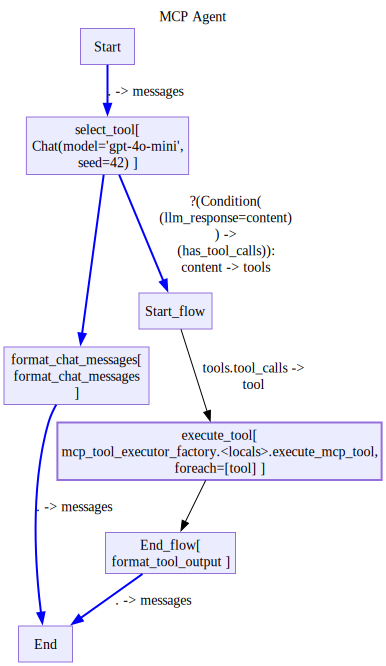

In [ ]:
execute_mcp_tool = mcp_tool_executor_factory(mcp_client)
mcp_chat = MCP_Chat_factory(tool_selector,execute_mcp_tool)
mcp_chat.draw(direction='TB')

In [ ]:
d0 = mcp_chat()
user_input = "What is love?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d0.run(messages):
    trace.pprint()

In [ ]:
d1 = mcp_chat()
user_input = "What information do I have about dogs in our wiki?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d1.run(messages):
    trace.pprint()

In [ ]:
d = mcp_chat()
user_input = user_query="What information do I have about dogs in our wiki, and what are the latest news or recent developments about dogs?"
messages = [
    {"role": "user", "content": user_input}
]
for trace in d.run(messages):
    trace.pprint()
    #trace.pprint(drop_keys=['input'])

# Diagram v4

In [ ]:
from pydantic import ConfigDict

In [ ]:
# State class to manage conversation history
class CustomState(BaseModel):
    model_config = ConfigDict(extra='allow')
    history:list[int] = list()

    def append_to_history(self, value: int | list[int]):
        if isinstance(value, list):
            self.history.extend(value)
        else:
            self.history.append(value)
    
    def get_history(self)->int:
        return self.history

In [ ]:
execute_mcp_tool = mcp_tool_executor_factory(mcp_client)
mcp_chat = MCP_Chat_factory(tool_selector,execute_mcp_tool)

In [ ]:
#| export
def has_tool_result(mcp_output: Dict[str, Any]) -> bool:
    """
    Check if the mcp_chat output contains at least one tool_result in messages.
    
    Args:
        mcp_output: Output from mcp_chat sub-diagram, should have a 'messages' key
        
    Returns:
        True if any message has content with type 'tool_result', False otherwise
    """    
    messages = mcp_output.get('messages', [])
    # Iterate through each message
    for message in messages:
        if not isinstance(message, dict):
            continue
            
        content = message.get('content', [])
        
        # Handle content as a list
        if isinstance(content, list):
            for item in content:
                if isinstance(item, dict) and item.get('type') == 'tool_result':
                    return True
        
        # Handle content as a string (no tool_result)
        elif isinstance(content, str):
            continue
    
    return False

In [ ]:

with Define('MCP Chat Loop', type='decision', state=CustomState()) as MCP_Chat_Loop:
    # Get user info/input
  E('Start->state/append_to_history')
    
    # Run MCP Chat as a sub-diagram
  V('mcp_chat', mcp_chat,
      inputs=['Start(_=.)',
      'State/get_history'],
      outputs=['State/append_to_history(0=messages)']
      )
  E('mcp_chat->mcp_chat', Condition(has_tool_result))
  E('mcp_chat->End')




python(59841) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


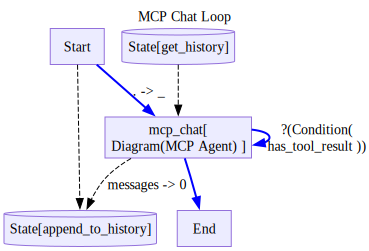

In [ ]:
MCP_Chat_Loop.draw(direction='TB')

In [ ]:
d = MCP_Chat_Loop()
user_input = "What information do I have about dogs in our wiki?"
message = {"role": "user", "content": user_input}
for trace in d.run(message):
    trace.pprint()
    print(d.state)

history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}, {'role': 'tool', 'tool_call_id': None, 'content': None}]


history=[{'role': 'user', 'content': 'What information do I have about dogs in our wiki?'}, {'role': 'tool', 'tool_call_id': None, 'content': None}]
